In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os


import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.cuda.amp import GradScaler
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"On device : {device}")

On device : cuda


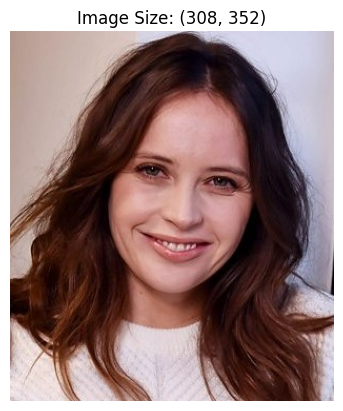

In [4]:
example_image_path = random.choice(os.listdir('../input/face-shape-dataset/FaceShape Dataset/training_set/Oval'))
example_image_path = os.path.join("../input/face-shape-dataset/FaceShape Dataset/training_set/Oval", example_image_path)
example_image = Image.open(example_image_path)

plt.imshow(example_image)
plt.title(f"Image Size: {example_image.size}")
plt.axis('off')
plt.show()

In [5]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [11]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() - 1
TRAIN_PATH = "../input/face-shape-dataset/FaceShape Dataset/training_set"
TEST_PATH = "../input/face-shape-dataset/FaceShape Dataset/testing_set"

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms, loader=safe_pil_loader)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=test_transforms, loader=safe_pil_loader)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [20]:
train_dataset.class_to_idx

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

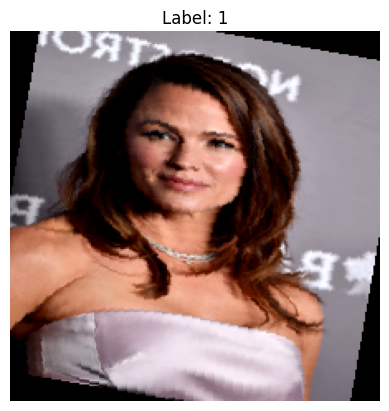

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

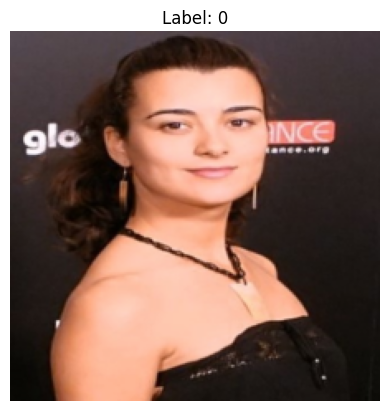

In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

In [16]:
torch.manual_seed(42)

model = torchvision.models.efficientnet_b4(pretrained=True)

num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
    )

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

model.to(device)
num_epochs = 25
best_val_loss = 1_000_000

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    train_losses =  []

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    model.eval()
    validation_losses = []
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
      for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        validation_losses.append(loss)

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

      avg_val_loss = sum(validation_losses) / len(validation_losses)
      scheduler.step(avg_val_loss)

      accuracy = accuracy_score(all_labels, all_predictions)
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

      if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), 'models/best_model.pth')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/25, Train Loss: 1.5967, Validation Loss: 1.6156, Accuracy: 0.3390
Epoch 2/25, Train Loss: 1.3882, Validation Loss: 1.3350, Accuracy: 0.5040
Epoch 3/25, Train Loss: 1.2159, Validation Loss: 1.1959, Accuracy: 0.5820
Epoch 4/25, Train Loss: 1.1017, Validation Loss: 1.1578, Accuracy: 0.6030
Epoch 5/25, Train Loss: 1.0248, Validation Loss: 1.2607, Accuracy: 0.6100
Epoch 6/25, Train Loss: 0.9398, Validation Loss: 0.9975, Accuracy: 0.7000
Epoch 7/25, Train Loss: 0.8779, Validation Loss: 0.9283, Accuracy: 0.7310
Epoch 8/25, Train Loss: 0.8247, Validation Loss: 0.9290, Accuracy: 0.7270
Epoch 9/25, Train Loss: 0.7809, Validation Loss: 0.9924, Accuracy: 0.7190
Epoch 10/25, Train Loss: 0.7450, Validation Loss: 1.0131, Accuracy: 0.7150
Epoch 00011: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/25, Train Loss: 0.7084, Validation Loss: 1.2038, Accuracy: 0.6630
Epoch 12/25, Train Loss: 0.5892, Validation Loss: 0.7536, Accuracy: 0.8470
Epoch 13/25, Train Loss: 0.5359, Validation Los